Loading data
Creating Model...


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Traning Model...
Test Loss: 0.4878
Test Accuracy: 0.7590
67/67 [==============================] - 5s 75ms/step
              precision    recall  f1-score   support

     Class 0       0.50      0.78      0.61      1071
     Class 1       0.49      0.21      0.30      1062

    accuracy                           0.50      2133
   macro avg       0.50      0.50      0.45      2133
weighted avg       0.50      0.50      0.45      2133



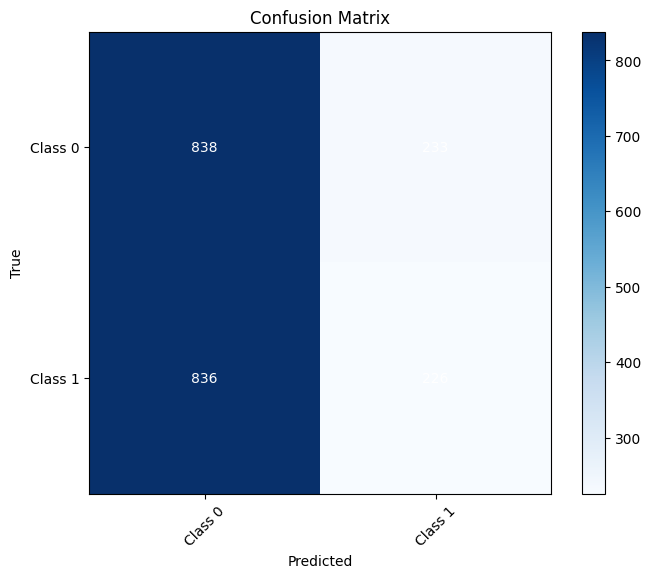

KeyError: ignored

<Figure size 800x600 with 0 Axes>

In [11]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split
from data_helpers import load_data

from keras.callbacks import Callback

class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))

accuracy_history = AccuracyHistory()

print('Loading data')
x, y, vocabulary, vocabulary_inv = load_data()

# x.shape -> (10662, 56)
# y.shape -> (10662, 2)
# len(vocabulary) -> 18765
# len(vocabulary_inv) -> 18765

X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

# X_train.shape -> (8529, 56)
# y_train.shape -> (8529, 2)
# X_test.shape -> (2133, 56)
# y_test.shape -> (2133, 2)


sequence_length = x.shape[1] # 56
vocabulary_size = len(vocabulary_inv) # 18765
embedding_dim = 256
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5

epochs = 20
batch_size = 30

# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=2, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_accuracy:.4f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
print("Traning Model...")
# model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint, accuracy_history], validation_data=(X_test, y_test))

# model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(X_test, y_test))  # starts training
from keras.models import load_model

# Load the trained model from the .hdf5 file
loaded_model = load_model('weights.006-0.7590.hdf5')  # Replace 'weights.best.hdf5' with the path to your saved model file


import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


# Evaluate the loaded model on the test data
loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Generate predictions on the test data using the loaded model
y_pred = loaded_model.predict(X_test)


# Generate predictions on the test data
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to binary labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Generate a classification report
class_names = ['Class 0', 'Class 1']  # Replace with your class names
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Create a confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(confusion[i, j]), horizontalalignment='center', verticalalignment='center', color='white')
plt.show()
